In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import itertools
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(2)

In [16]:
data = pd.read_csv('bankPortfolios.csv')

In [17]:
data.head()

,2699,6107,9965,1036,2924,3786,4573,1087,617,76.827,769,1828.2,381,933,32673,1
0,759920.0,6480.0,588660.0,528110.0,1188700.0,169400.0,174890.0,10210.0,6566.0,21101.00,211210.0,428740.0,82487.0,68882.0,3770300.0,1
1,129080.0,729.0,72972.0,3310.0,73909.0,34.0,44928.0,32995.0,409.0,502.00,15599.0,57902.0,20800.0,12168.0,423250.0,1
2,57828.0,1449.8,27634.0,1739.0,39274.0,1838.3,9854.0,1900.0,321.0,228.98,2291.9,7696.0,4609.0,7823.0,145830.0,1
3,1021.0,14222.0,3186.0,35.0,4776.0,29645.0,9295.0,3245.0,493.0,215.00,4932.0,20818.0,891.0,3661.0,87600.0,1
4,149560.0,93281.0,211800.0,7950.0,151300.0,16933.0,32142.0,2020.0,880.0,3106.00,17057.0,137950.0,12992.0,22517.0,792090.0,1


## PROCESSING DATA

In [18]:
from sklearn.preprocessing import StandardScaler
# normalizing the data for all the columns except for the last one
sc = StandardScaler()
data.iloc[:, :-1] = sc.fit_transform(data.iloc[:, :-1])


In [19]:
# change the last column name 1 to 'Class'
data.rename(columns={'1': 'Class'}, inplace=True)
data.head()

,2699,6107,9965,1036,2924,3786,4573,1087,617,76.827,769,1828.2,381,933,32673,Class
0,0.626612,-0.039225,0.021046,1.363177,0.581567,0.278336,-0.007969,-0.037124,-0.023536,0.033683,0.048713,0.024422,0.203004,0.003597,0.087925,1
1,0.028024,-0.048131,-0.034434,-0.055347,-0.047822,-0.057001,-0.040954,-0.031949,-0.028403,-0.048722,-0.036377,-0.038803,0.006786,-0.036993,-0.039332,1
2,-0.039585,-0.047015,-0.039312,-0.059593,-0.067376,-0.053429,-0.049856,-0.039011,-0.028472,-0.049814,-0.042165,-0.047362,-0.044715,-0.040103,-0.049880,1
3,-0.093488,-0.027235,-0.041942,-0.064199,-0.086853,0.001627,-0.049998,-0.038706,-0.028336,-0.049870,-0.041017,-0.045125,-0.056542,-0.043081,-0.052094,1
4,0.047457,0.095199,-0.019499,-0.042805,-0.004129,-0.023542,-0.044200,-0.038984,-0.028030,-0.038304,-0.035743,-0.025155,-0.018050,-0.029586,-0.025309,1


In [20]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [21]:
y.head()

,Class
0,1
1,1
2,1
3,1
4,1


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [23]:
X_train.shape

(5447, 15)

In [24]:
X_test.shape

(2335, 15)

## Random Forest Model

In [25]:
# Initialize the Random Forest classifier with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=0)


In [26]:
# Define the search space for hyperparameter tuning
search_spaces = {
    'n_estimators': (10, 500),
    'max_depth': (5, 50),
    'min_samples_split': (2, 11),
    'min_samples_leaf': (1, 11)
}


In [27]:
# Set up Bayesian Optimization
opt = BayesSearchCV(rf, search_spaces, n_iter=32, scoring='f1_macro', n_jobs=-1, cv=5, random_state=0)

# Fit the model
opt.fit(X_train, y_train.values.ravel())

# Best model after Bayesian Optimization
best_model = opt.best_estimator_


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=True, # True for normalization and False for normalization
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Define the threshold for changing the text color in the blocks
    thresh = cm.max() / 2.

    # Annotate the blocks
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}\n(TP)" if i == j and i == 1 else
                 f"{cm[i, j]:.2f}\n(TN)" if i == j and i == 0 else
                 f"{cm[i, j]:.2f}\n(FP)" if j == 1 else
                 f"{cm[i, j]:.2f}\n(FN)",
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [29]:
# Predictions
y_pred = best_model.predict(X_test)
y_test = pd.DataFrame(y_test)

In [30]:
# Evaluation
print("Best Parameters:", opt.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: OrderedDict([('max_depth', 50), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 396)])
Accuracy: 0.9494646680942184
Precision: 0.705118278121914
Recall: 0.6506672601531525
F1 Score: 0.6730064465901431

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2226
           1       0.44      0.32      0.37       109

    accuracy                           0.95      2335
   macro avg       0.71      0.65      0.67      2335
weighted avg       0.94      0.95      0.95      2335



Confusion Matrix 
[[2182   44]
 [  74   35]]
Normalized confusion matrix
[[0.9802336  0.0197664 ]
 [0.67889908 0.32110092]]


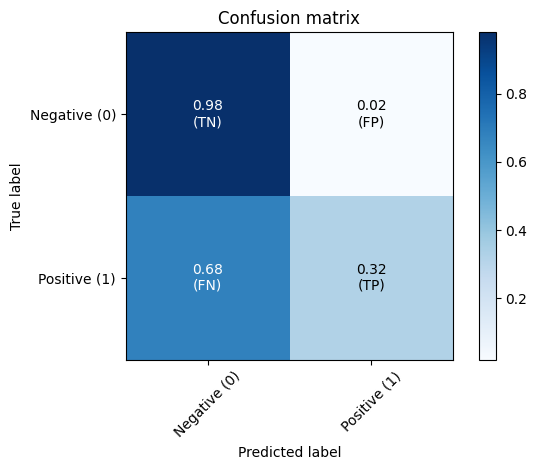

In [32]:
cnf_matrix = confusion_matrix(y_test, y_pred.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])

Confusion Matrix 
[[7364  113]
 [  77  228]]
Normalized confusion matrix
[[0.98488699 0.01511301]
 [0.25245902 0.74754098]]


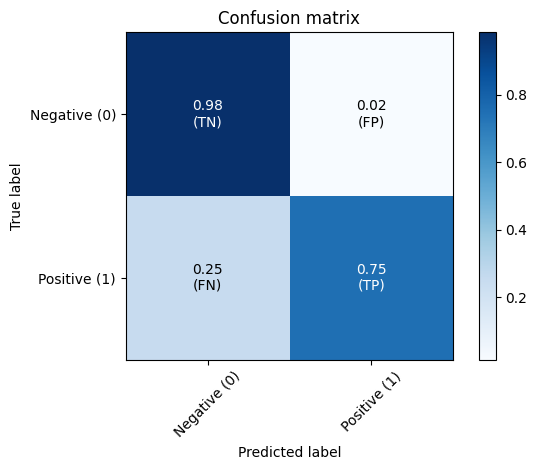

In [35]:
y_pred = best_model.predict(X)
y_expected = pd.DataFrame(y)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])
plt.show()

## SMOTE
Creates synthetic samples of the minority class.

In [37]:
sm = SMOTE(random_state=123)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train_smote,y_train_smote,test_size=0.3)

In [38]:
# Initialize the Random Forest classifier with balanced class weights
rf_1 = RandomForestClassifier(class_weight='balanced', random_state=0)


In [39]:
# Define the search space for hyperparameter tuning
search_spaces = {
    'n_estimators': (10, 500),
    'max_depth': (5, 50),
    'min_samples_split': (2, 11),
    'min_samples_leaf': (1, 11)
}


In [40]:
# Set up Bayesian Optimization
opt = BayesSearchCV(rf_1, search_spaces, n_iter=32, scoring='f1_macro', n_jobs=-1, cv=5, random_state=0)

# Fit the model
opt.fit(X_train, y_train.values.ravel())

# Best model after Bayesian Optimization
best_model_1 = opt.best_estimator_

In [41]:
# Predictions
y_pred_1 = best_model_1.predict(X_test)
y_test_1 = pd.DataFrame(y_test)

In [42]:
# Evaluation
print("Best Parameters:", opt.best_params_)
print("Accuracy:", accuracy_score(y_test_1, y_pred_1))
print("Precision:", precision_score(y_test_1, y_pred_1, average='macro'))
print("Recall:", recall_score(y_test_1, y_pred_1, average='macro'))
print("F1 Score:", f1_score(y_test_1, y_pred_1, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_1, y_pred_1))

Best Parameters: OrderedDict([('max_depth', 32), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])
Accuracy: 0.97429387496033
Precision: 0.9743973779665702
Recall: 0.9743113736751607
F1 Score: 0.974293036081969

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1579
           1       0.97      0.98      0.97      1572

    accuracy                           0.97      3151
   macro avg       0.97      0.97      0.97      3151
weighted avg       0.97      0.97      0.97      3151



Confusion Matrix 
[[1526   53]
 [  28 1544]]
Normalized confusion matrix
[[0.96643445 0.03356555]
 [0.0178117  0.9821883 ]]


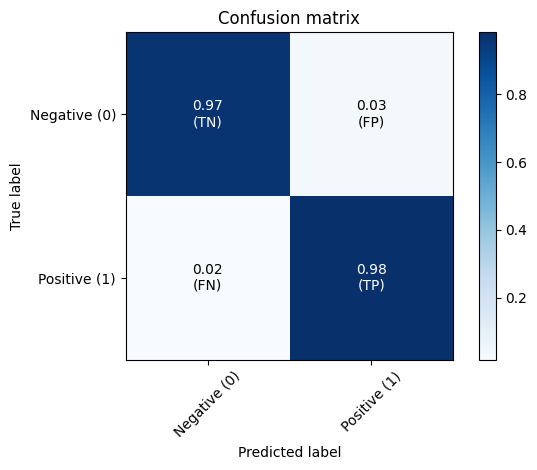

In [43]:
cnf_matrix = confusion_matrix(y_test_1, y_pred_1.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])

Confusion Matrix 
[[7332  145]
 [  74  231]]
Normalized confusion matrix
[[0.9806072  0.0193928 ]
 [0.24262295 0.75737705]]


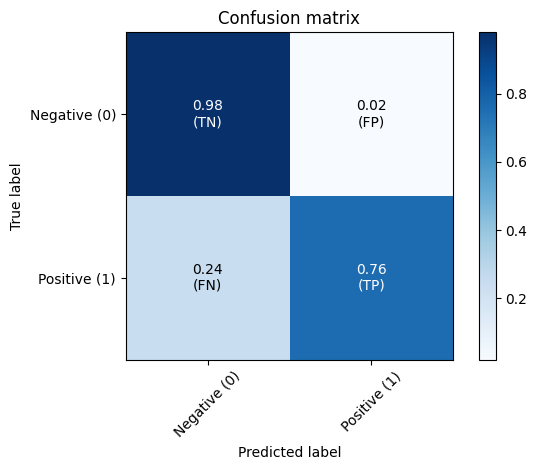

In [44]:
y_pred_1 = best_model_1.predict(X)
y_expected = pd.DataFrame(y)
# Evaluation
print("Best Parameters:", opt.best_params_)
print("Accuracy:", accuracy_score(y_expected, y_pred_1))
print("Precision:", precision_score(y_expected, y_pred_1, average='macro'))
print("Recall:", recall_score(y_expected, y_pred_1, average='macro'))
print("F1 Score:", f1_score(y_expected, y_pred_1, average='macro'))
print("\nClassification Report:\n", classification_report(y_expected, y_pred_1))

In [ ]:
cnf_matrix = confusion_matrix(y_expected, y_pred_1.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])
plt.show()

## ADASYN
Similar to SMOTE but with a focus on generating synthetic data for those minority class instances that are harder to learn.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [49]:
# Initialize the ADASYN object
adasyn = ADASYN(random_state=42)

# Apply ADASYN resampling
X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [50]:
# Initialize the Random Forest classifier with balanced class weights
rf_2 = RandomForestClassifier(class_weight='balanced', random_state=0)


In [51]:
# Define the search space for hyperparameter tuning
search_spaces = {
    'n_estimators': (10, 500),
    'max_depth': (5, 50),
    'min_samples_split': (2, 11),
    'min_samples_leaf': (1, 11)
}

In [52]:
# Set up Bayesian Optimization
opt = BayesSearchCV(rf_2, search_spaces, n_iter=32, scoring='f1_macro', n_jobs=-1, cv=5, random_state=0)

# Fit the model
opt.fit(X_train, y_train.values.ravel())

# Best model after Bayesian Optimization
best_model_2 = opt.best_estimator_

In [53]:
# Predictions of the test set
y_pred_2 = best_model_2.predict(X_test)
y_test_2= pd.DataFrame(y_test)

In [54]:
# Evaluation
print("Best Parameters:", opt.best_params_)
print("Accuracy:", accuracy_score(y_test_2, y_pred_2))
print("Precision:", precision_score(y_test_2, y_pred_2, average='macro'))
print("Recall:", recall_score(y_test_2, y_pred_2, average='macro'))
print("F1 Score:", f1_score(y_test_2, y_pred_2, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_2, y_pred_2))

Best Parameters: OrderedDict([('max_depth', 29), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])
Accuracy: 0.9293361884368309
Precision: 0.6043003064351379
Recall: 0.6052099046300189
F1 Score: 0.6047525105948178

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2226
           1       0.25      0.25      0.25       109

    accuracy                           0.93      2335
   macro avg       0.60      0.61      0.60      2335
weighted avg       0.93      0.93      0.93      2335



Confusion Matrix 
[[2143   83]
 [  82   27]]
Normalized confusion matrix
[[0.96271339 0.03728661]
 [0.75229358 0.24770642]]


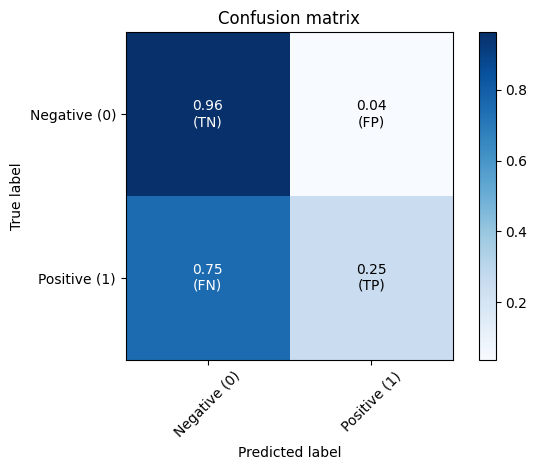

In [55]:
cnf_matrix = confusion_matrix(y_test_2, y_pred_2.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])

In [56]:
# predictions of the entire dataset
y_pred_2 = best_model_2.predict(X)
y_expected = pd.DataFrame(y)

In [57]:
# Evaluation
print("Best Parameters:", opt.best_params_)
print("Accuracy:", accuracy_score(y_expected, y_pred_2))
print("Precision:", precision_score(y_expected, y_pred_2, average='macro'))
print("Recall:", recall_score(y_expected, y_pred_2, average='macro'))
print("F1 Score:", f1_score(y_expected, y_pred_2, average='macro'))
print("\nClassification Report:\n", classification_report(y_expected, y_pred_2))

Best Parameters: OrderedDict([('max_depth', 29), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])
Accuracy: 0.9787972243639167
Precision: 0.8588948688089468
Recall: 0.8600234160715813
F1 Score: 0.8594581625809972

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7477
           1       0.73      0.73      0.73       305

    accuracy                           0.98      7782
   macro avg       0.86      0.86      0.86      7782
weighted avg       0.98      0.98      0.98      7782



Confusion Matrix 
[[7332  145]
 [  74  231]]
Normalized confusion matrix
[[0.9806072  0.0193928 ]
 [0.24262295 0.75737705]]


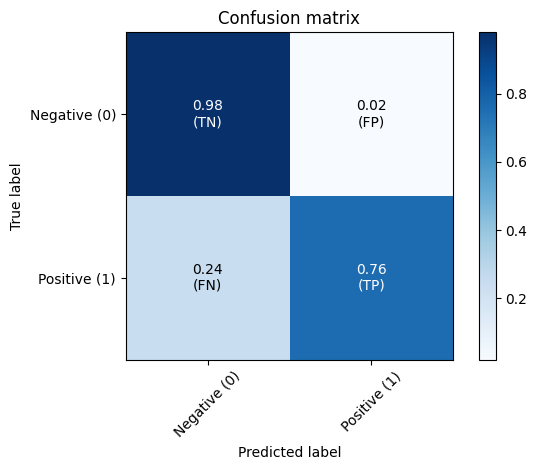

In [58]:
cnf_matrix = confusion_matrix(y_expected, y_pred_1.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])
plt.show()